In [102]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as io
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [5]:
# Data directory
datadir = '/home/justin/Data/seam/'
d_train_f = datadir + 'training_data.mat'
d_test_f = datadir + 'blind_data.mat'

In [21]:
# Load the matlab files for training and testing (blind) boreholes
d_train = io.loadmat(d_train_f)
d_test = io.loadmat(d_test_f)

In [55]:
# Parse the matlab data structures to get training/testing images and labels
labels_train,images_train = d_train['ctrain'][0],d_train['dtrain'][0]
labels_test,images_test = d_test['cblind'][0],d_test['dblind'][0]


In [100]:
# Print some information
print(' ### INFO ###')
print('%i Training Data Boreholes' %(len(images_train)))
print('%i Testing Data Boreholes' %(len(images_test)))
print('%i Classes' %(labels_train[0].shape[0]))
print('%i Values per Image (%i x %i)\n'%(images_train[0].shape[0], np.sqrt(images_train[0].shape[0]), np.sqrt(images_train[0].shape[0])))

cnt = 1
for x,l in zip(images_train,labels_train):
    xv = np.reshape(x,x.size)
    print('Borehole %2i:  %i Depth Slices | Min: %-4.3f   Max: %-4.3f   Mean: % 7.2f   Std: %-4.3f' %(cnt, x.shape[1], xv.min(), xv.max(), xv.mean(), xv. std()))
    cnt += 1

 ### INFO ###
11 Training Data Boreholes
5 Testing Data Boreholes
4 Classes
25 Values per Image (5 x 5)

Borehole  1: 707 Depth Slices | Min: -19841.348   Max: 28279.582   Mean:  -10.96   Std: 4471.869
Borehole  2: 689 Depth Slices | Min: -18987.617   Max: 27663.824   Mean:  -39.07   Std: 4270.490
Borehole  3: 697 Depth Slices | Min: -14817.008   Max: 23764.441   Mean:   62.60   Std: 3502.549
Borehole  4: 691 Depth Slices | Min: -17115.027   Max: 19057.191   Mean:   19.58   Std: 3449.588
Borehole  5: 660 Depth Slices | Min: -18968.973   Max: 21860.555   Mean:    5.75   Std: 3506.990
Borehole  6: 676 Depth Slices | Min: -18961.461   Max: 29092.922   Mean:  -12.60   Std: 4207.515
Borehole  7: 702 Depth Slices | Min: -21064.227   Max: 30714.266   Mean:  -25.05   Std: 4467.483
Borehole  8: 706 Depth Slices | Min: -19675.383   Max: 22419.102   Mean:   24.54   Std: 3528.093
Borehole  9: 583 Depth Slices | Min: -12698.621   Max: 17069.480   Mean:  -47.61   Std: 3405.394
Borehole 10: 665 Depth

In [162]:
# Define a plotting function
def montageArray(x, img_size, ncol=50):
    xx = np.reshape(x, (img_size,img_size,-1))
    fig = plt.figure()
    fig.set_size_inches(30,20)
    fig.subplots_adjust(wspace=0.0)
    n = xx.shape[2]
    for i in range(n):   
        a = fig.add_subplot(np.ceil(n/float(ncol)), ncol, i+1)
        
        plt.imshow(xx[:,:,i])
        plt.axis('off')
    plt.show()
        

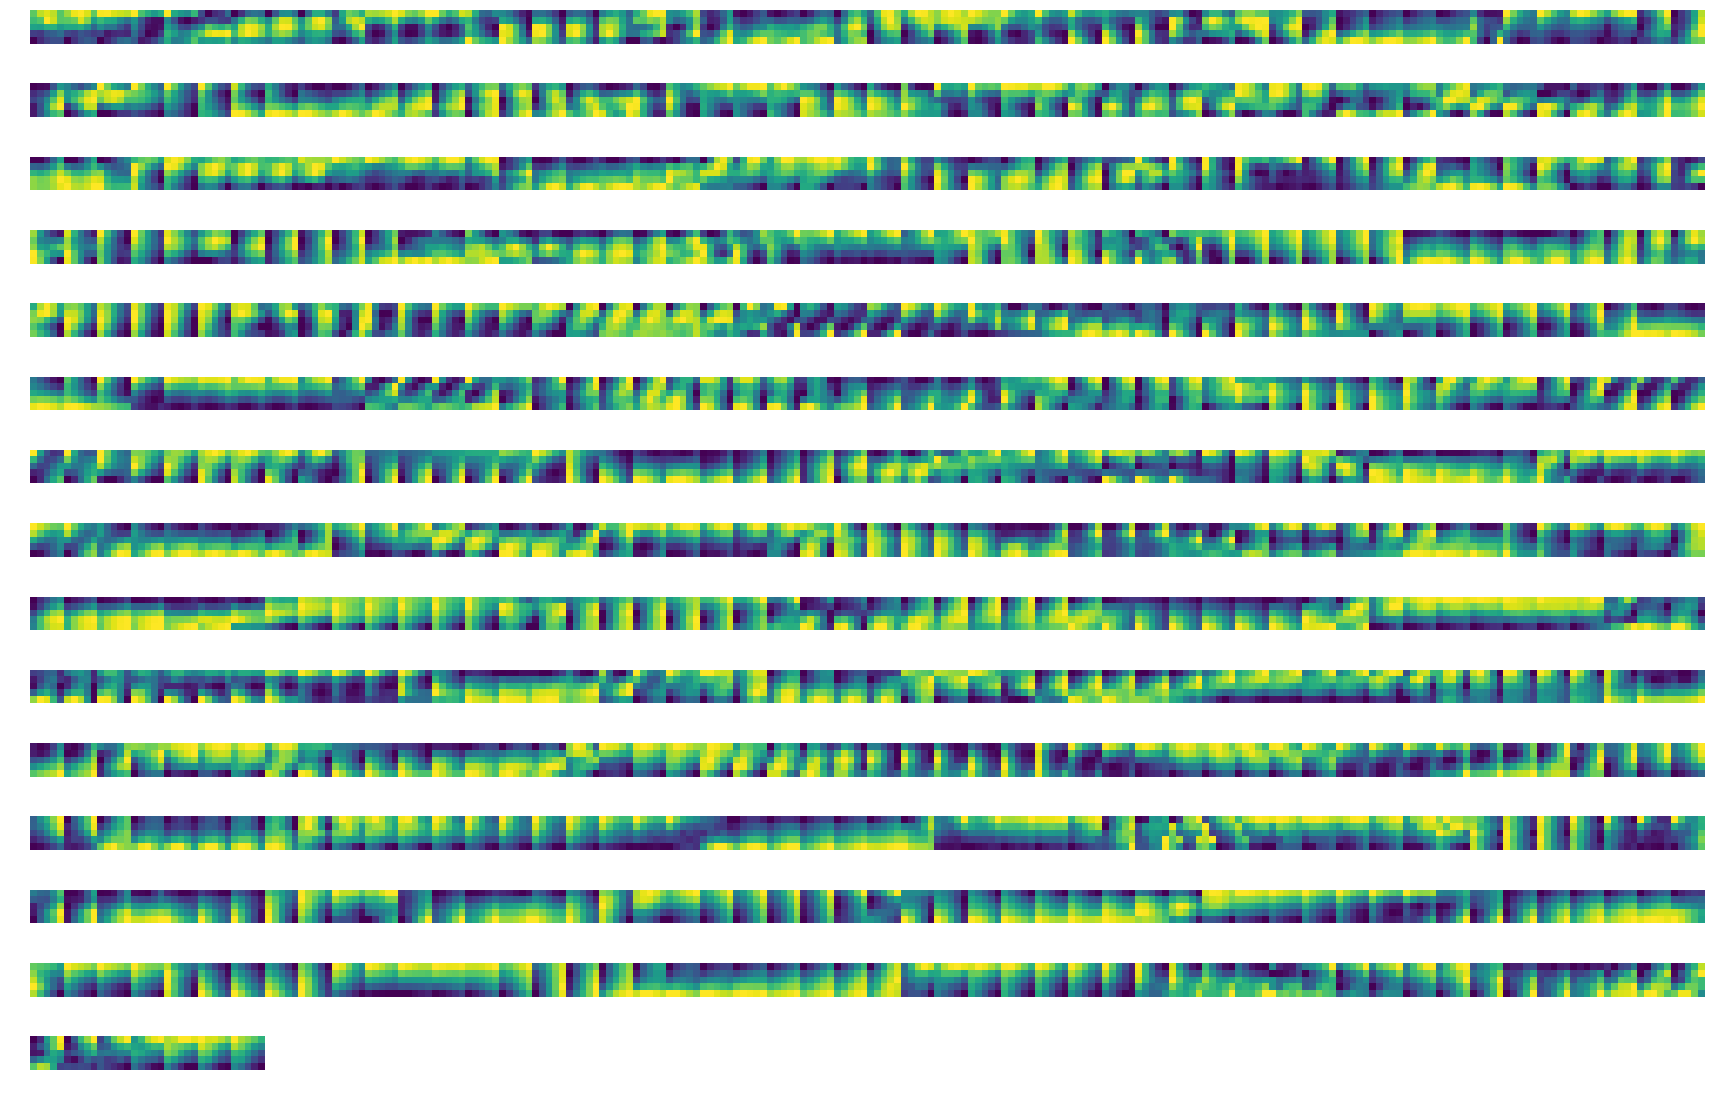

In [163]:
# View the data
montageArray(images_train[0],5)

In [247]:
# Change the labels to integers
labels = []
for label in labels_train:
    l = [np.where(y)[0][0] for y in label.transpose()]
    labels.append(np.asarray(l))

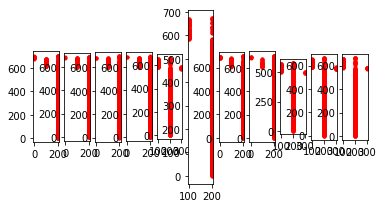

In [272]:
# View the labels
fig = plt.figure()
for i,ll in enumerate(labels):
    a = fig.add_subplot(1, len(labels), i+1)
    plt.plot(100*ll,np.arange(len(ll)),'r.')
    plt.axis('image')
plt.show()

In [ ]:
# Normalize the data


In [314]:
# Format the data and labels for PyTorch
# Images should be formatted as [1,1,X,Y,Z] for each Borehole
Ytrain = []
for y in images_train:
    Ytrain.append(np.reshape(y,(1,1,5,5,-1)))
    
Ytest = []
for y in images_test:
    Ytest.append(np.reshape(y,(1,1,5,5,-1)))
    
# Labels should be formatted as [4,Z] for each Borehole
Ctrain = list(labels_train)
Ctest = list(labels_test)